## simplifying read addition code to "bulk" process

### 3/8 GW20 V1 S1

In [22]:
sticr_fp = '/media/chang/HDD-11/mgkeefe/230317_local_STICR/barcodes/bc_outs_V1_S1/'
flat_3_filename = '3_flat.txt'
flat_E_filename = 'E_flat.txt'
sticr_filename = 'Final_Barcodes.tsv'
sample_prefix = 'GW20_V1_S1'

scar_fp = '/media/chang/HDD-11/mgkeefe/230317_local_STICR/barcodes/bc_outs_V1_S1/'
scar_filename = 'GW20_0308_V1_S1_bcs_final_metadata_UMIs.csv'
scar_new_filename = 'GW20_0308_V1_S1_bcs_final_metadata_UMIs_reads.csv'

In [25]:
input_E_flat = pd.read_csv(sticr_fp+flat_E_filename, sep='\t', names=['read', 'barcode'])
input_E_flat[['Read_ID', 'UMI', 'CBC']] = input_E_flat.read.str.split("_", expand = True)
input_E_flat['CBC_barcode'] = input_E_flat["CBC"]+"_IndexE_"+input_E_flat["barcode"]
print(input_E_flat.shape)

input_3_flat = pd.read_csv(sticr_fp+flat_3_filename, sep='\t', names=['read', 'barcode'])
input_3_flat[['Read_ID', 'UMI', 'CBC']] = input_3_flat.read.str.split("_", expand = True)
input_3_flat['CBC_barcode'] = input_3_flat["CBC"]+"_Index3_"+input_3_flat["barcode"]
print(input_3_flat.shape)

input_flat = pd.concat([input_E_flat, input_3_flat])
print(input_flat.shape)


del(input_E_flat)
del(input_3_flat)

(38337857, 6)
(16316920, 6)
(54654777, 6)


In [26]:
unique_reads_df = pd.DataFrame(input_flat['CBC_barcode'].value_counts())
unique_reads_df = unique_reads_df.rename(columns={"CBC_barcode": "read_counts"})
unique_reads_df["CBC_barcode"] = unique_reads_df.index

In [27]:
scar_umi = pd.read_csv(scar_fp+scar_filename, index_col=0)
scar_umi['CBC_barcode'] =  scar_umi['CBC']+"_"+scar_umi['Clone_barcodes']
scar_umi_reads = scar_umi.merge(unique_reads_df)

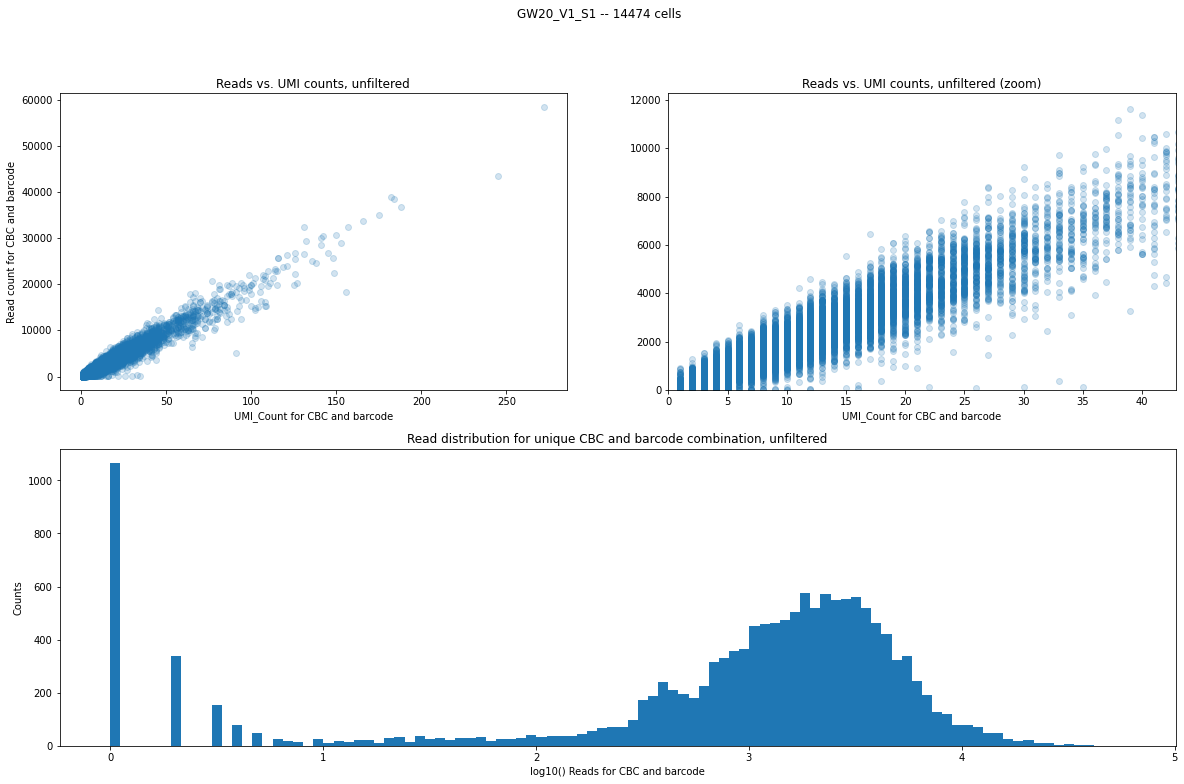

In [97]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(scar_umi_reads['UMI_Count'], scar_umi_reads['read_counts'], alpha=0.2)
ax1.set_xlabel('UMI_Count for CBC and barcode')
ax1.set_ylabel('Read count for CBC and barcode')
ax1.set_title('Reads vs. UMI counts, unfiltered')
max_xlim = ax1.get_xlim()
max_ylim = ax1.get_ylim()

ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(scar_umi_reads['UMI_Count'], scar_umi_reads['read_counts'], alpha=0.2)
ax2.set_xlabel('UMI_Count for CBC and barcode')
#ax2.set_ylabel('Read count for CBC and barcode')
ax2.set_title('Reads vs. UMI counts, unfiltered (zoom)')
ax2.set_xlim(0, 0.15*max_xlim[1])
ax2.set_ylim(0, 0.2*max_ylim[1])

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(np.log10(scar_umi_reads['read_counts']), bins=100)
ax3.set_xlabel('log10() Reads for CBC and barcode')
ax3.set_ylabel('Counts')
ax3.set_title('Read distribution for unique CBC and barcode combination, unfiltered')

fig.suptitle(sample_prefix + ' -- ' + str(scar_umi_reads.shape[0]) + ' cells')
fig.savefig(scar_fp+sample_prefix+'_unfiltered_reads_umis.jpg', dpi=300, bbox_inches='tight')
fig.show()

In [80]:
read_thresh = 10
scar_umi_reads_filt = scar_umi_reads.loc[scar_umi_reads['read_counts'] >= read_thresh]

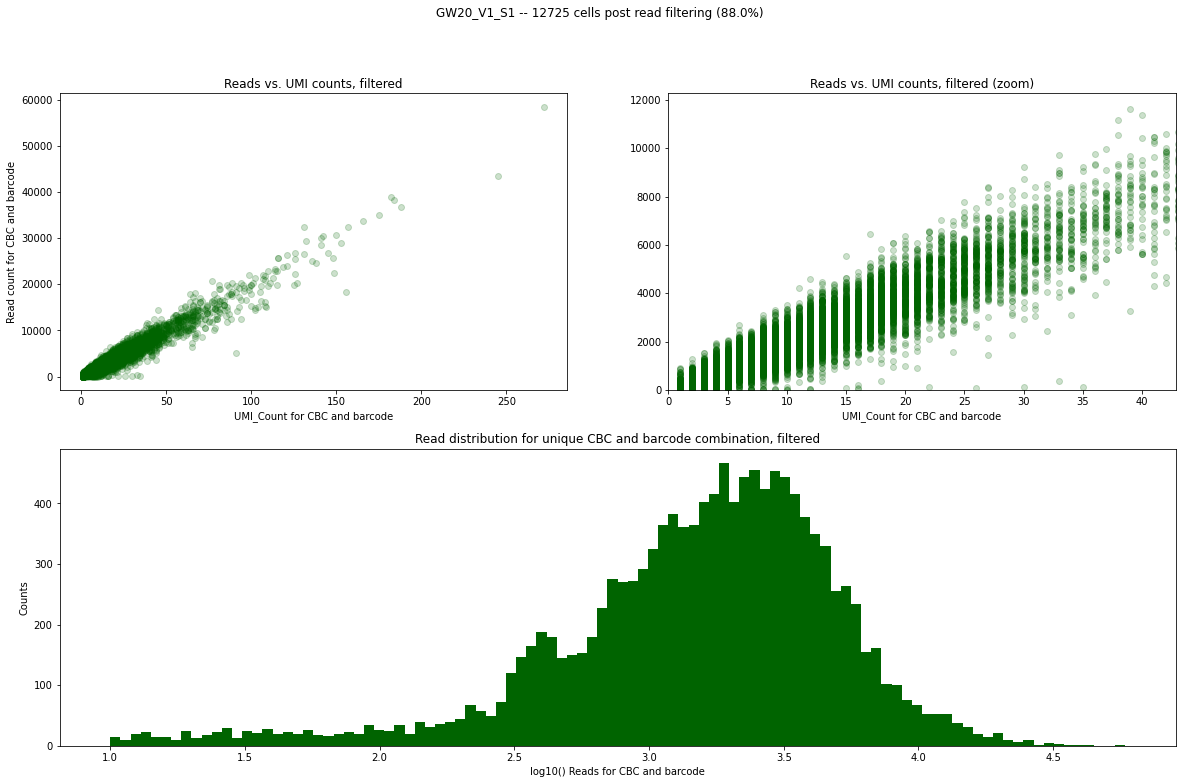

In [98]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(scar_umi_reads_filt['UMI_Count'], scar_umi_reads_filt['read_counts'], alpha=0.2, color='darkgreen')
ax1.set_xlabel('UMI_Count for CBC and barcode')
ax1.set_ylabel('Read count for CBC and barcode')
ax1.set_title('Reads vs. UMI counts, filtered')
max_xlim = ax1.get_xlim()
max_ylim = ax1.get_ylim()

ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(scar_umi_reads_filt['UMI_Count'], scar_umi_reads_filt['read_counts'], alpha=0.2, color='darkgreen')
ax2.set_xlabel('UMI_Count for CBC and barcode')
#ax2.set_ylabel('Read count for CBC and barcode')
ax2.set_title('Reads vs. UMI counts, filtered (zoom)')
ax2.set_xlim(0, 0.15*max_xlim[1])
ax2.set_ylim(0, 0.2*max_ylim[1])

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(np.log10(scar_umi_reads_filt['read_counts']), bins=100, color='darkgreen')
ax3.set_xlabel('log10() Reads for CBC and barcode')
ax3.set_ylabel('Counts')
ax3.set_title('Read distribution for unique CBC and barcode combination, filtered')

fig.suptitle(sample_prefix + ' -- ' + str(scar_umi_reads_filt.shape[0]) + ' cells post read filtering (' + 
             str(np.round(scar_umi_reads_filt.shape[0]/scar_umi_reads.shape[0]*100))+'%)')
fig.savefig(scar_fp+sample_prefix+'_filtered_reads_umis.jpg', dpi=300, bbox_inches='tight')
fig.show()

In [99]:
scar_umi_reads['thresh_pass'] = [False]*len(scar_umi_reads['read_counts'])
scar_umi_reads['thresh_pass'][scar_umi_reads['read_counts'] >= read_thresh] = True
scar_umi_reads.to_csv(scar_fp+scar_new_filename)